# Coursework: Mammographic density prediction

In this coursework, you will implement a model for breast tissue density prediction from digital screening mammography data. Mammograms are X‑ray images acquired as part of regular breast cancer screening programmes. Breast tissue density is an important risk factor and is categorised into four classes according to the BI‑RADS (Breast Imaging Reporting and Data System) standard:
- Class A – Almost entirely fatty: The breast is composed mostly of fatty tissue with minimal fibroglandular density.
- Class B – Scattered areas of fibroglandular density: There are some dense areas, but most of the tissue is still fatty.
- Class C – Heterogeneously dense: Many areas of dense tissue are present, which may obscure small masses.
- Class D – Extremely dense: The breast is composed predominantly of dense tissue, making mammographic interpretation and cancer detection more challenging.

Your task is to develop and evaluate a predictive model capable of automatically assigning these density categories from mammographic images. You will be asked to assess the performance of the model across different subgroups, and conduct a model inspection using dimensionality reduction of feature embeddings.

The coursework is divided in the following parts:

* **Part A**: Choose a sensible data augmentation pipeline within the `MammoDataset` class.
* **Part B**: Implement a sensible model for image classification within the `MammoNet` class.
* **Part C**: Conduct a subgroup performance analysis.
* **Part D**: Inspect the trained model by analysing feature embeddings.
* **Part E**: Write a short report about your coursework (using the [provided template](https://www.overleaf.com/read/rkjxjntdfdwr#df7c9e)).

**Important:** Read the text descriptions carefully and look out for hints and comments indicating a specific **TASK**. Make sure to add sufficient documentation and comments to your code.

**Submission:** You are asked to submit two files:
1. You should submit this notebook in `.ipynb` format with *all outputs included*. Please name your file `notebook.ipynb`.
2. You should also submit a short report in `.pdf` format, using [this template](https://www.overleaf.com/read/rkjxjntdfdwr#df7c9e). Please name this file `report.pdf`.

### Your details

Please add your details below. You can work in groups up to two.

Authors: **firstname1 lastname1** & **firstname2 lastname2**

DoC username: **alias1** & **alias2**

### Setup

In [ ]:
# On Google Colab uncomment the following line to install additional libraries
! pip install lightning
! pip install stocaching

# See the requirements.txt file for more details on the required libraries.
# We recommend using a virtual environment to manage dependencies.
# For example, you can create a virtual environment using venv:
# python3 -m venv myenv
# source myenv/bin/activate
# pip install -r requirements.txt

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as T
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

from matplotlib import cm
from ipywidgets import Output, HBox
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import decomposition
from sklearn.manifold import TSNE
from skimage.io import imread
from skimage.util import img_as_ubyte
from torchmetrics.functional import auroc
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from stocaching import SharedCache
#from torchsampler import ImbalancedDatasetSampler

In [2]:
from typing import Callable

import pandas as pd
import torch
import torch.utils.data
import torchvision


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset

    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(
        self,
        dataset,
        labels: list = None,
        indices: list = None,
        num_samples: int = None,
        callback_get_label: Callable = None,
    ):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset) if labels is None else labels
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

    def _get_labels(self, dataset):
        if self.callback_get_label:
            return self.callback_get_label(dataset)
        elif isinstance(dataset, torch.utils.data.TensorDataset):
            return dataset.tensors[1]
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels.tolist()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torchvision.datasets.DatasetFolder):
            return dataset.samples[:][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[:][1]
        elif isinstance(dataset, torch.utils.data.Dataset):
            return dataset.get_labels()
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

### Data

We make use of the publicly available [RSNA-SMBC dataset](https://registry.opendata.aws/rsna-screening-mammography-breast-cancer-detection/). We have preproceesed this dataset to make it easier to work with. We have reduced the image sizes to 128x96 and simplified the meta information.

Note, unzipping the dataset will take a few minutes, as there almost 30,000 images. Only needs to be done once.

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/rsna-small.zip
! unzip -q rsna-small.zip # Remove -q for verbose output

In [3]:
DATA_DIR = './data/rsna-small'
CSV_FILE = os.path.join(DATA_DIR, 'meta.csv')
IMAGE_SIZE = (128, 96)
NUM_CLASSES = 4

Let's check the meta information of the dataset.

In [4]:
df_meta = pd.read_csv(CSV_FILE)
df_meta.head()

,image_id,laterality,view,age,cancer,implant,density,machine_id,study_id,split
0,1967300488,L,MLO,60.0,0,0,C,216,10038,training
1,2142944869,L,CC,60.0,0,0,C,216,10038,training
2,850559196,R,MLO,60.0,0,0,C,216,10038,training
3,1350492010,R,CC,60.0,0,0,C,216,10038,training
4,102733848,L,CC,51.0,0,0,C,93,10042,training


Let's visualise some random samples from each density class. You can run this cell repeatedly to see different samples.

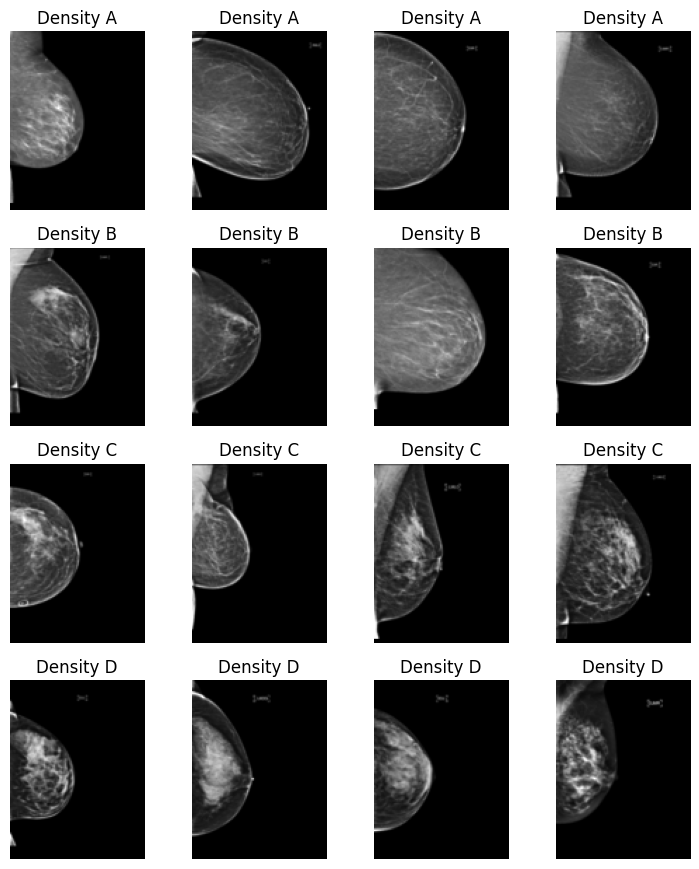

In [5]:
N_PER_CLASS = 4  # Number of images per class to display
CLASSES_DISPLAY = ["A", "B", "C", "D"] # Breast density classes for display

df_meta["img_path"] = [
    os.path.join(
        DATA_DIR, "images",
        str(df_meta.study_id.values[i]),
        str(df_meta.image_id.values[i]) + ".png"
    )
    for i in range(len(df_meta))
]

# display sample images from each class
fig, axes = plt.subplots(len(CLASSES_DISPLAY), N_PER_CLASS, figsize=(1.9 * N_PER_CLASS, 2.2 * len(CLASSES_DISPLAY)))
if N_PER_CLASS == 1: # In case of single column, expand dims
    axes = np.expand_dims(axes, axis=1)

for r, cls in enumerate(CLASSES_DISPLAY):
    sub = df_meta[df_meta["density"] == cls]
    k = min(N_PER_CLASS, len(sub))
    sample_idx = np.random.choice(len(sub), size=k, replace=False)
    samples = sub.iloc[sample_idx]
    for c in range(N_PER_CLASS):
        ax = axes[r, c]
        ax.axis("off")
        if c < k:
            img = imread(samples.iloc[c]["img_path"])
            ax.imshow(img, cmap="gray")
            ax.set_title(f"Density {cls}", fontsize=12)
plt.tight_layout()
plt.show()


## **Part A**: Choose a sensible data augmentation pipeline within the `MammoDataset` class.

We provide a custom [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) that manages the RSNA-SMBC dataset.

**TASK:** Implement data augmentation for mammography images. You can use the `torchvision.transforms.v2` module to select a sensible set of photometric and geometric transformations. Report your choices in the coursework report.

In [6]:
class MammoDataset(Dataset):
    def __init__(self, data, image_size, image_normalization, augmentation = False, cache_size = 0):
        self.image_normalization = image_normalization
        self.do_augment = augmentation

        # photometric data augmentation: small intensity variation.
        # For mammograms, brightness/contrast and mild histogram-type transforms are plausible.
        self.photometric_augment = T.Compose([
            # Mild brightness/contrast jitter
            T.RandomApply([T.ColorJitter(brightness=0.10, contrast=0.15)], p=0.8),
            
            # Occasionally apply simple global intensity remappings
            T.RandomApply([T.RandomAutocontrast()], p=0.15),
            T.RandomApply([T.RandomEqualize()], p=0.10),

            # Very mild blur to simulate acquisition variability
            T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.10)
        ])

        # geometric data augmentation: small pose/position perturbations
        self.geometric_augment = T.Compose([
            T.RandomHorizontalFlip(p=0.5),

            # Small and gentle affine: rotation/translation/scale
            T.RandomAffine(
                degrees=7, # small rotation
                translate=(0.02, 0.02), # small shift (fraction of image)
                scale=(0.95, 1.05), # slight zoom in/out
                shear=0, # avoid shearing mammograms
                interpolation=T.InterpolationMode.BILINEAR,
                fill=0 # background stays black
            )
        ])

        # load metadata into numpy arrays for faster access
        self.img_paths = data.img_path.to_numpy()
        self.study_ids = data.study_id.to_numpy()
        self.image_ids = data.image_id.to_numpy()
        self.labels = data.labels.to_numpy()

        # cache for preprocessed images to speed up training after the first epoch
        self.cache = None
        self.use_cache = cache_size > 0
        if self.use_cache:
            self.cache = SharedCache(
                size_limit_gib=cache_size,
                dataset_len=self.labels.shape[0],
                data_dims=(1, image_size[0], image_size[1]),
                dtype=torch.float32,
            )

    def preprocess(self, image):
        # breast segmentation using connected components
        image_norm = image - np.min(image)
        image_norm = image_norm / np.max(image_norm)
        thresh = cv2.threshold(img_as_ubyte(image_norm), 5, 255, cv2.THRESH_BINARY)[1]
        nb_components, output, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=4)

        # Find the largest non background component.
        max_label, _ = max(
            [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)],
            key=lambda x: x[1],
        )
        mask = output == max_label
        image[mask == 0] = 0

        return image

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        image = None
        if self.use_cache:
            image = self.cache.get_slot(index)

        if image is None:
            img_path = self.img_paths[index]
            image = imread(img_path).astype(np.float32)
            image = self.preprocess(image)
            image = torch.from_numpy(image).unsqueeze(0)

            if self.use_cache:
                self.cache.set_slot(index, image, allow_overwrite=True)

        # normalize intensities to range [0,1]
        image = image / self.image_normalization

        if self.do_augment:
            image = self.photometric_augment(image)
            image = self.geometric_augment(image)

        # convert to 3-channel image to be compatible with pretrained models
        image = image.repeat(3, 1, 1)

        return {'image': image, 'label': self.labels[index], 'study_id': self.study_ids[index], 'image_id': self.image_ids[index]}

    def get_labels(self):
        return self.labels


We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for preparing the RSNA-SMBC dataset and its training, validation and test splits. No changes required here but make sure that you understand what is happening within this module.

In [7]:
class MammoDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, csv_file, image_size, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_workers = num_workers

        # load metadata
        self.data = pd.read_csv(csv_file)

        # construct image paths from metadata
        self.data['img_path'] = [os.path.join(self.data_dir, 'images', str(self.data.study_id.values[idx]), str(self.data.image_id.values[idx]) + '.png') for idx in range(0, len(self.data))]

        # Define image labels based on breast density classes
        # self.data['labels'] = self.data['density']
        # self.data.loc[self.data['labels'] == 'A', 'labels'] = 0
        # self.data.loc[self.data['labels'] == 'B', 'labels'] = 1
        # self.data.loc[self.data['labels'] == 'C', 'labels'] = 2
        # self.data.loc[self.data['labels'] == 'D', 'labels'] = 3
        self.data['labels'] = self.data['density'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3}) 

        # Use pre-defined splits to separate data into train, val and testing
        self.train_data = self.data[self.data['split'] == 'training']
        self.val_data = self.data[self.data['split'] == 'validation']
        self.test_data = self.data[self.data['split'] == 'test']

        # create dataset objects for each split
        self.train_set = MammoDataset(self.train_data, self.image_size, image_normalization=65535.0, augmentation=True, cache_size=2)
        self.val_set = MammoDataset(self.val_data, self.image_size, image_normalization=65535.0, augmentation=False, cache_size=0.5)
        self.test_set = MammoDataset(self.test_data, self.image_size, image_normalization=65535.0, augmentation=False)

        # print dataset statistics
        train_labels = self.train_set.get_labels()
        train_class_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])

        val_labels = self.val_set.get_labels()
        val_class_count = np.array([len(np.where(val_labels == t)[0]) for t in np.unique(val_labels)])

        test_labels = self.test_set.get_labels()
        test_class_count = np.array([len(np.where(test_labels == t)[0]) for t in np.unique(test_labels)])

        print('samples (train): ',len(self.train_set))
        print('samples (val):   ',len(self.val_set))
        print('samples (test):  ',len(self.test_set))
        print('class counts (train): ', train_class_count)
        print('class counts (val):   ', val_class_count)
        print('class counts (test):  ', test_class_count)
        print('class % (train): ', np.array([f"{x:.2f}" for x in np.array(train_class_count/len(train_labels)*100.0)]))
        print('class % (val):   ', np.array([f"{x:.2f}" for x in np.array(val_class_count/len(val_labels)*100.0)]))
        print('class % (test):  ', np.array([f"{x:.2f}" for x in np.array(test_class_count/len(test_labels)*100.0)]))

    def train_dataloader(self):
        # we use ImbalancedDatasetSampler to handle class imbalance in the training set
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, sampler=ImbalancedDatasetSampler(self.train_set), num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

## **Part B**: Implement a sensible model for image classification within the `MammoNet` class.

We use a [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) for implementing the model and its training and testing steps.

**TASK:** Implement and try out different models suitable for the breast density prediction problem. Check out the `torchvision.models` module. Report your choices in the coursework report.

In [8]:
class MammoNet(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=0.0001):
        super().__init__()
        self.num_classes = num_classes
        self.lr = learning_rate

        # Use Resnet18 pretrained model for image classification
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        num_features = self.model.fc.in_features

        # Replace final layer for 4-class output
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes),
        )

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # AdamW for weifhr decay regularisation
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)

        # Reduce LR when validation AUC plateus
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.5,
            patience=3
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_auc'}
        }

    def process_batch(self, batch):
        img, lab = batch['image'], batch['label']
        out = self.forward(img)
        prd = torch.softmax(out, dim=1)
        loss = F.cross_entropy(out, lab)
        return loss, prd, lab

    def on_train_epoch_start(self):
        self.train_preds = []
        self.train_trgts = []

    def training_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('train_loss', loss, batch_size=lab.shape[0])
        self.train_preds.append(prd.detach().cpu())
        self.train_trgts.append(lab.detach().cpu())
        if batch_idx == 0:
            images = batch['image'][0:4, ...].detach().cpu()
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True)
            self.logger.experiment.add_image('images', grid, self.global_step)
        return loss

    def on_train_epoch_end(self):
        self.train_preds = torch.cat(self.train_preds, dim=0)
        self.train_trgts = torch.cat(self.train_trgts, dim=0)
        auc = auroc(self.train_preds, self.train_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('train_auc', auc)
        self.train_preds = []
        self.train_trgts = []

    def on_validation_epoch_start(self):
        self.val_preds = []
        self.val_trgts = []

    def validation_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('val_loss', loss, batch_size=lab.shape[0])
        self.val_preds.append(prd.detach().cpu())
        self.val_trgts.append(lab.detach().cpu())

    def on_validation_epoch_end(self):
        self.val_preds = torch.cat(self.val_preds, dim=0)
        self.val_trgts = torch.cat(self.val_trgts, dim=0)
        auc = auroc(self.val_preds, self.val_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('val_auc', auc)
        self.val_preds = []
        self.val_trgts = []

    def on_test_epoch_start(self):
        self.test_preds = []
        self.test_trgts = []
        self.test_study_ids = []
        self.test_image_ids = []

    def test_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('test_loss', loss, batch_size=lab.shape[0])
        self.test_preds.append(prd.detach().cpu())
        self.test_trgts.append(lab.detach().cpu())
        self.test_study_ids.append(batch['study_id'].detach().cpu())
        self.test_image_ids.append(batch['image_id'].detach().cpu())

    def on_test_epoch_end(self):
        self.test_preds = torch.cat(self.test_preds, dim=0)
        self.test_trgts = torch.cat(self.test_trgts, dim=0)
        auc = auroc(self.test_preds, self.test_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('test_auc', auc)
    
    def get_embeddings(self, x):                                                                                                
      x = self.model.conv1(x)                                     
      x = self.model.bn1(x)                                       
      x = self.model.relu(x)                                      
      x = self.model.maxpool(x)                                   
      x = self.model.layer1(x)                                    
      x = self.model.layer2(x)                                    
      x = self.model.layer3(x)                                    
      x = self.model.layer4(x)                                    
      x = self.model.avgpool(x)                                   
      x = torch.flatten(x, 1)                                        
      return x

### Training

We use the PyTorch Lightning [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) for easy training and testing. You may need to adjust the number of epochs, but otherwise you should be able to just run the cell and wait for the training to complete.

**TASK:** Adjust the number of epochs if needed. Report any observations about the training in your coursework report (you may want to check training and validation curves via Tensorboard).

In [9]:
pl.seed_everything(42, workers=True)

output_base = './output/'
output_name = 'mammo-net'
output_dir = os.path.join(output_base, output_name)

data = MammoDataModule(data_dir=DATA_DIR, csv_file=CSV_FILE, image_size=IMAGE_SIZE, batch_size=256, num_workers=0)

model = MammoNet(num_classes=NUM_CLASSES, learning_rate=1e-4)  # lower lr

trainer = pl.Trainer(
    max_epochs=15,
    accelerator='auto',
    devices=1,
    log_every_n_steps=5,
    logger=TensorBoardLogger(save_dir=output_base, name=output_name),
    callbacks=[ModelCheckpoint(monitor="val_auc", mode='max'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

Seed set to 42


Dataset size (1.0 GiB) fits in cache limit (2 GiB). Allocating space to cache all 21204 samples.
Dataset size (0.1 GiB) fits in cache limit (0.5 GiB). Allocating space to cache all 2368 samples.
samples (train):  21204
samples (val):    2368
samples (test):   5865
class counts (train):  [2224 9057 8856 1067]
class counts (val):    [ 247 1034  938  149]
class counts (test):   [ 628 2548 2368  321]
class % (train):  ['10.49' '42.71' '41.77' '5.03']
class % (val):    ['10.43' '43.67' '39.61' '6.29']
class % (test):   ['10.71' '43.44' '40.38' '5.47']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ ResNet │ 11.2 M │ train │     0 │
└───┴───────┴────────┴────────┴───────┴───────┘

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 70                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/vol/bitbucket/ll4122/myenv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/vol/bitbucket/ll4122/myenv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


### Validation

Evaluate the trained model with the best checkpoint on the validation data and report the classification performance.

**TASK:** You should report the validation performance and some information about the model checkpoint in the coursework report (at what epoch/iteration did you find the best checkpoint).

In [10]:
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./output/mammo-net/version_2/checkpoints/epoch=3-step=332.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./output/mammo-net/version_2/checkpoints/epoch=3-step=332.ckpt
/vol/bitbucket/ll4122/myenv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_auc          │    0.9251251816749573     │
│         val_loss          │    0.5962163805961609     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5962163805961609, 'val_auc': 0.9251251816749573}]

### Testing

Evaluate the trained model with the best checkpoint on the test data and report the classification performance.

**TASK:** You should report the test performance in the coursework report.

In [11]:
def save_predictions(model, output_fname):
    std_ids = [id.numpy() for sublist in model.test_study_ids for id in sublist]
    img_ids = [id.numpy() for sublist in model.test_image_ids for id in sublist]
    cols_names = ['class_' + str(i) for i in range(0, NUM_CLASSES)]
    df = pd.DataFrame(data=model.test_preds.numpy(), columns=cols_names)
    df['target'] = model.test_trgts.numpy()
    df['study_id'] = std_ids
    df['image_id'] = img_ids
    df.to_csv(output_fname, index=False)

In [12]:
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
save_predictions(model=model, output_fname=os.path.join(output_dir, 'predictions.csv'))

Restoring states from the checkpoint path at ./output/mammo-net/version_2/checkpoints/epoch=3-step=332.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./output/mammo-net/version_2/checkpoints/epoch=3-step=332.ckpt
/vol/bitbucket/ll4122/myenv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.9199622869491577     │
│         test_loss         │    0.6063741445541382     │
└───────────────────────────┴───────────────────────────┘

## **Part C**: Conduct a subgroup performance analysis.

The code below allows you to check the model performance by plotting the [ROC curves](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and calculating the per-class [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) metrics over the whole test set.

**TASK:** Using different attributes from the meta information, conduct several subgroup performance analyses, and report the results in the coursework report. Note any interesting observations.

In [13]:
df_pred = pd.read_csv(os.path.join(output_dir, 'predictions.csv'))

In [14]:
class_columns = [col for col in df_pred.columns if col.startswith('class_')]
preds = np.stack([df_pred[col] for col in class_columns]).T
targets = np.array(df_pred['target'])

roc_results = {}

for i, class_name in enumerate(class_columns):
    pos_label = i
    y = np.array(targets)
    y[targets != pos_label] = 0
    y[targets == pos_label] = 1

    fpr, tpr, _ = roc_curve(y, preds[:, pos_label])
    roc_auc = auc(fpr, tpr)

    roc_results[class_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

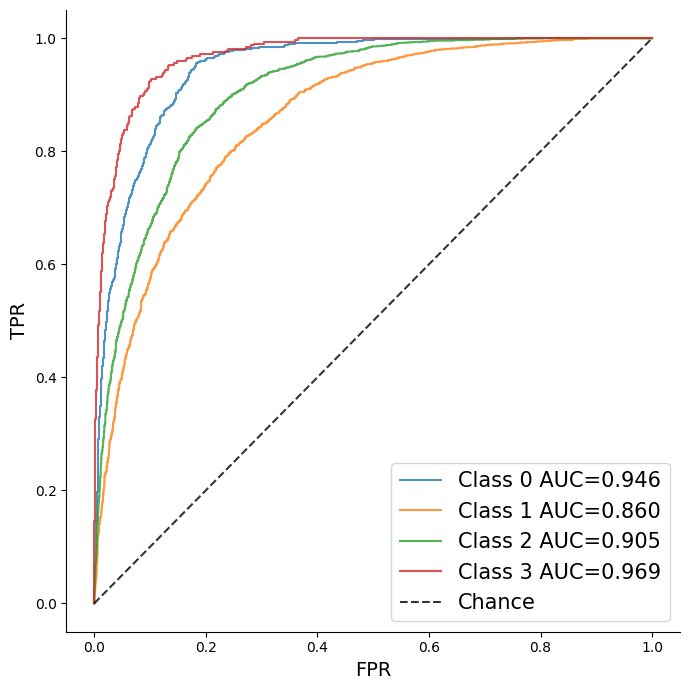

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))

for i, (class_name, metrics) in enumerate(roc_results.items()):
    label = f"Class {i} AUC={metrics['roc_auc']:.3f}"
    plt.plot(metrics['fpr'], metrics['tpr'], lw=1.5, alpha=.8, label=label)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.legend(loc="lower right", fontsize=15)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

We merge files predictions and meta information, and define helper functions useful for subgroup analysis. We bin age values into several intervals.

In [16]:
from sklearn.preprocessing import label_binarize

df = df_pred.merge(
    df_meta,
    on=["study_id", "image_id"],
    how="left",
    validate="one_to_one"
)

print("Distinct age:", df_meta["age"].nunique())
print(df_meta["age"].unique())

# -------------- Helper functions --------------
def make_bins(df_in, bins, labels, col="age", col_out="age_bin"):
    """
    Create age bins. NaN will note be assigned to any bin.
    """
    df_out = df_in.copy()
    # Left closed, right open interval
    df_out[col_out] = pd.cut(df_out[col], bins=bins, labels=labels, right=False)
    return df_out

def macro_roc_curve(y_true, y_score, n_classes=NUM_CLASSES):
    """
    Multi-class macro-average ROC:
    - Compute ovr ROC per class
    - Interpolate TPRs onto FPR grid
    - Average TPR across classes get macro ROC
    Returns: fpr_grid, tpr_macro, macro_auc
    Note: 
    - If some class is missing positives/negatives, the class is skipped
    """
    # Binarize y for ovr
    Y = label_binarize(y_true, classes=np.arange(n_classes)) # shape: (N, n_classes)

    # FPR grid for interpolation
    fpr_grid = np.linspace(0.0, 1.0, 1001)

    tprs = []
    valid_classes = 0

    for k in range(n_classes):
        y_k = Y[:, k]

        # ROC undefined if no pos/neg
        if y_k.sum() == 0 or y_k.sum() == len(y_k):
            continue

        fpr_k, tpr_k, _ = roc_curve(y_k, y_score[:, k])
        
        # Interpolation on grid
        tpr_interp = np.interp(fpr_grid, fpr_k, tpr_k)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        valid_classes += 1

    if valid_classes == 0:
        return None, None, np.nan
    
    tpr_macro = np.mean(np.vstack(tprs), axis=0)
    tpr_macro[-1] = 1.0
    macro_auc = auc(fpr_grid, tpr_macro)
    return fpr_grid, tpr_macro, macro_auc

Distinct age: 63
[60. 51. 52. 38. 44. 40. 71. 58. 76. 55. 61. 64. 50. 70. 56. 65. 63. 47.
 62. 54. 69. 85. 57. 72. 41. 49. 45. 43. 46. 53. 67. 74. 59. 48. 83. 89.
 73. 68. 78. 42. 80. 86. 66. 79. nan 75. 82. 39. 81. 36. 88. 77. 37. 28.
 84. 87. 32. 35. 34. 26. 30. 31. 33. 29.]


Generate plot of ROC curve and calculate AUC for each attribute.

In [17]:
def plot_roc_attr(df_in, subgroup_col):
    """
    One plot per attribute: overlays macro ROC curve for each subgroup.
    - Drops NaN values
    - Optional top_k for subgroup cols with many distinct values
    - min_n filters groups with few samples
    """
    df_groups = df_in.copy()

    # Drop NaN 
    df_groups = df_groups[df_groups[subgroup_col].notna()].copy()

    plt.figure(figsize=(7, 7))
    any_plot = False

    # Generate plot for each subgroup
    for group, df_group in df_groups.groupby(subgroup_col, sort=False):

        y = df_group["target"].to_numpy()
        proba = df_group[class_columns].to_numpy()

        fpr_grid, tpr_macro, macro_auc = macro_roc_curve(y, proba)
        if fpr_grid is None:
            # subgroup has no valid classes for ROC
            continue

        plt.plot(fpr_grid, tpr_macro, lw=1.5, alpha=.8, label=f"{group}, AUC={macro_auc:.3f}")
        any_plot = True

    plt.plot([0, 1], [0, 1], "k--", lw=1.5, label="Chance")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("FPR", fontsize=14)
    plt.ylabel("TPR", fontsize=14)
    plt.legend(loc="lower right", fontsize=15)
    plt.tight_layout()
    plt.show()

    if not any_plot:
        print(f"No subgroups plotted for {subgroup_col}")

/tmp/ipykernel_1307758/3475174338.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df_group in df_groups.groupby(subgroup_col, sort=False):


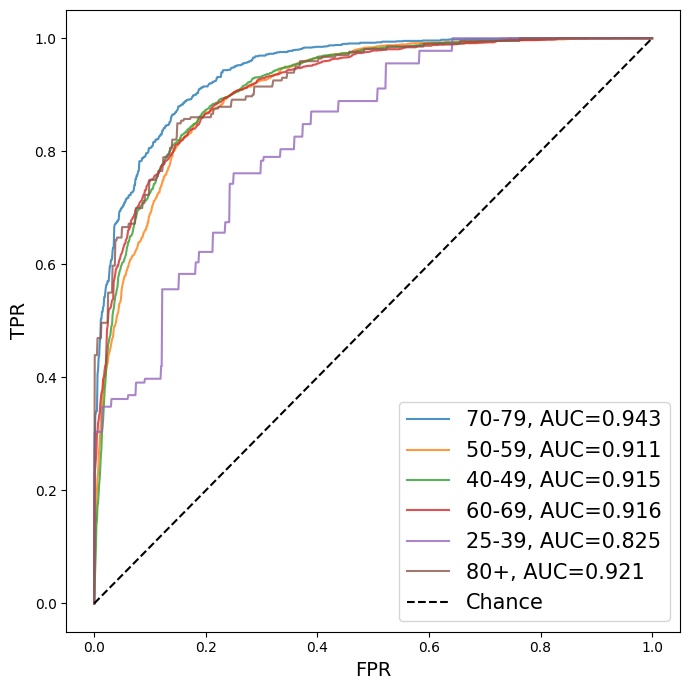

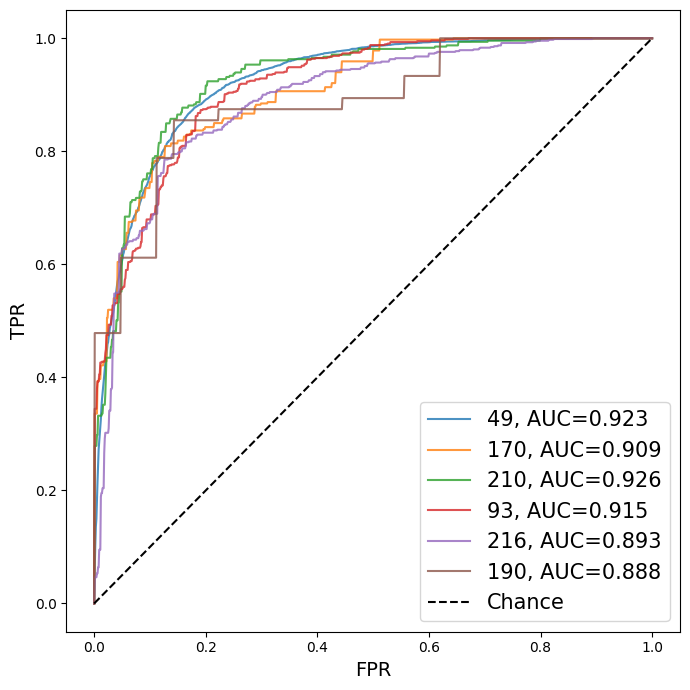

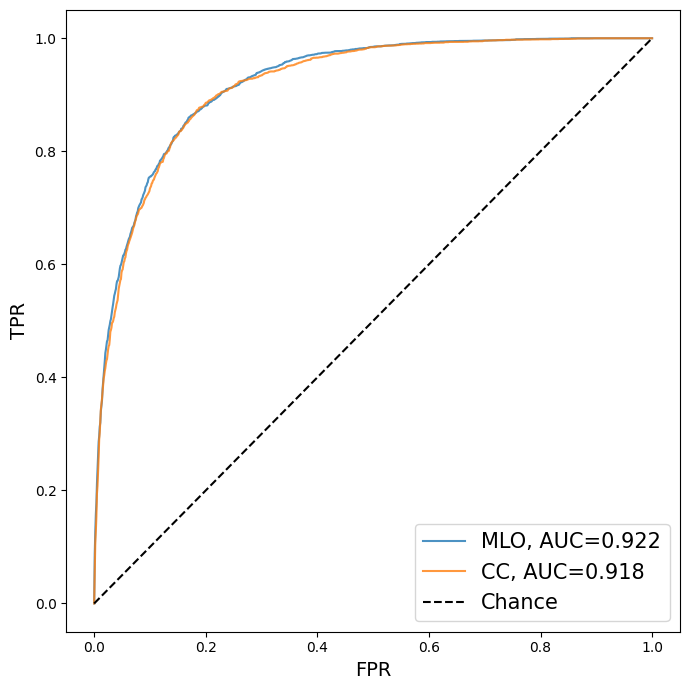

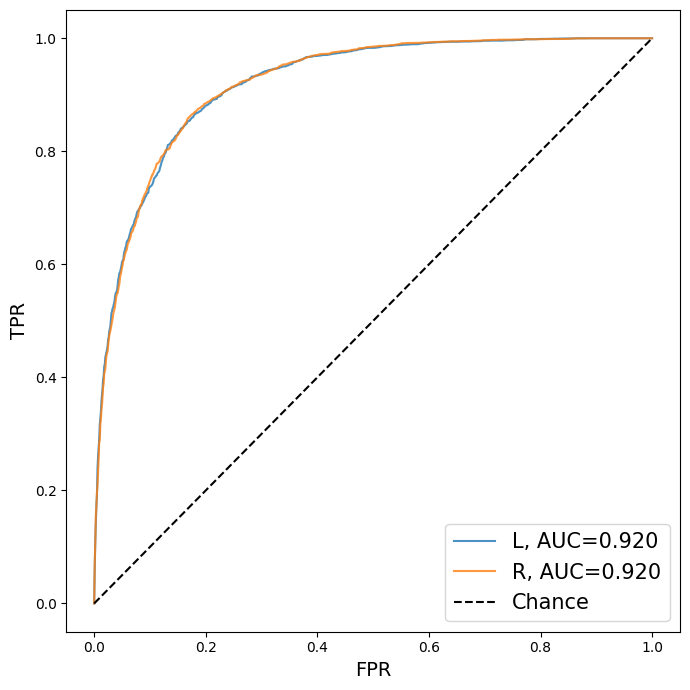

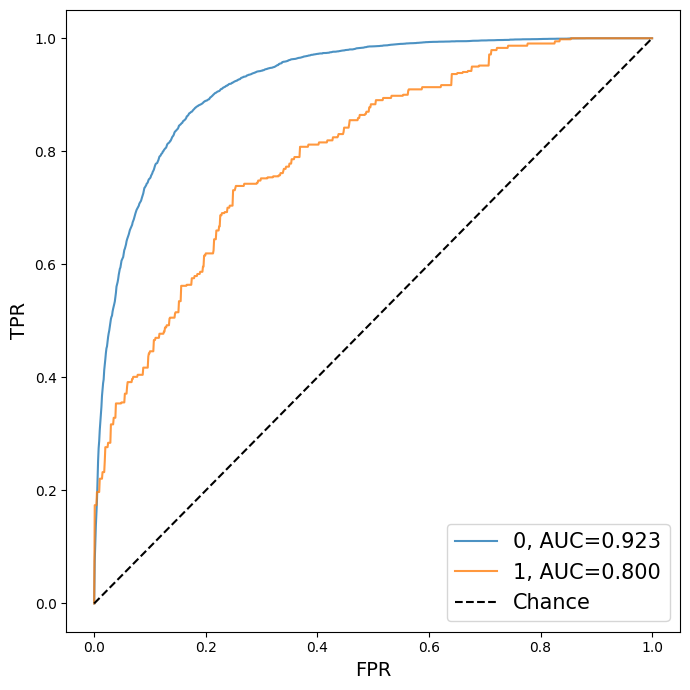

In [18]:
# Create Age bins
bins = [25, 40, 50, 60, 70, 80, 95]
age_labels = ["25-39", "40-49", "50-59", "60-69", "70-79", "80+"]
df = make_bins(df, bins, age_labels)

# ----- Run subgroup plots -----
# Age comparison
plot_roc_attr(df, subgroup_col="age_bin")

# Machine_id comparison
plot_roc_attr(df, subgroup_col="machine_id")

# View comparison
plot_roc_attr(df, subgroup_col="view")

# Laterality comparison
plot_roc_attr(df, subgroup_col="laterality")

# Implant comparison
plot_roc_attr(df, subgroup_col="implant")

## **Part D**: Inspect the trained model by analysing feature embeddings.

### Extract embeddings

We first need to extract the feature embeddings from the classification model.

**TASK:** Adapt the code below and make it work for your classification model. You only need to adapt the functions `on_test_epoch_start` and `test_step`.

In [19]:
# derived class to extract embeddings for visualization in addition to predictions
class MammoNetEmbeddings(MammoNet):
    def __init__(self, num_classes, learning_rate=0.0001):
        super().__init__(num_classes, learning_rate)
        self.embeddings = [] # list where we still store the embeddings

    def on_test_epoch_start(self):
        # self.model[2] = nn.Identity(512) # replace final classification layer with identity to get embeddings
        self.embeddings = [] # clear the list of embeddings at the start of testing

    def test_step(self, batch, batch_idx):
        x = batch['image']
        emb = self.get_embeddings(x)
        self.embeddings.append(emb.detach().cpu())

    # Override to disable other test logging of base class
    def on_test_epoch_end(self):
        pass

In [20]:
def save_embeddings(model, output_fname):
    embeddings = torch.cat(model.embeddings, dim=0).cpu().numpy()
    df = pd.DataFrame(data=embeddings)
    df.to_csv(output_fname, index=False)

In [21]:
model_emb = MammoNetEmbeddings(num_classes=NUM_CLASSES)
trainer.test(model=model_emb, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
save_embeddings(model=model_emb, output_fname=os.path.join(output_dir, 'embeddings.csv'))
output_frame = os.path.join(output_dir, 'embeddings.csv')

Restoring states from the checkpoint path at ./output/mammo-net/version_2/checkpoints/epoch=3-step=332.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./output/mammo-net/version_2/checkpoints/epoch=3-step=332.ckpt
/vol/bitbucket/ll4122/myenv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

### Model inspection

Now that we extracted the feature embeddings for the test set, we can combine this information with the meta data and the model predictions.

**TASK:** Adapt the provided code to conduct a model inspection, using different projections from different dimensionality reduction techniques, and overlay different types of meta information. Report the your findings in the coursework report. Note any interesting observations.

In [22]:
df_meta = pd.read_csv(CSV_FILE)
df_pred = pd.read_csv(os.path.join(output_dir, 'predictions.csv'))
df = pd.merge(df_pred, df_meta, how='inner', on=['image_id', 'study_id'])

In [23]:
embeddings = pd.read_csv(os.path.join(output_dir, 'embeddings.csv')).to_numpy()
print(embeddings.shape)

(5865, 512)


Next, we run PCA to reduce the dimenionality of the feature embeddings.

In [24]:
pca = decomposition.PCA(n_components=4, whiten=False)
embeddings_pca = pca.fit_transform(embeddings)

print(embeddings_pca.shape)

(5865, 4)


In [25]:
df['pca_1'] = embeddings_pca[:,0]
df['pca_2'] = embeddings_pca[:,1]
df['pca_3'] = embeddings_pca[:,2]
df['pca_4'] = embeddings_pca[:,3]

In [26]:
embeddings_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(embeddings_pca)

print(embeddings_tsne.shape)

(5865, 2)


In [27]:
df['tsne_1'] = embeddings_tsne[:,0]
df['tsne_2'] = embeddings_tsne[:,1]

df.head() # showing the first five entries in the dataframe

,class_0,class_1,class_2,class_3,target,study_id,image_id,laterality,view,age,...,implant,density,machine_id,split,pca_1,pca_2,pca_3,pca_4,tsne_1,tsne_2
0,0.000277,0.164669,0.834427,0.000627,2,10226,461614796,L,MLO,71.0,...,0,C,49,test,6.510309,8.002769,3.398798,-0.883367,5.938177,52.615807
1,0.000239,0.275946,0.723630,0.000184,2,10226,530620473,L,CC,71.0,...,0,C,49,test,4.193303,10.680296,4.455483,3.812616,-29.339497,60.347935
2,0.000446,0.198248,0.799432,0.001874,2,10226,309353373,R,CC,71.0,...,0,C,49,test,5.739315,7.754706,1.486369,0.599130,-3.260035,46.213993
3,0.000284,0.213963,0.785554,0.000198,2,10226,348710745,R,MLO,71.0,...,0,C,49,test,5.259597,8.827233,4.806804,-2.480643,1.765781,57.684971
4,0.000166,0.273548,0.726180,0.000107,2,10226,806376890,R,MLO,71.0,...,0,C,49,test,4.766064,10.412544,5.096806,0.116672,-8.868733,61.301067


In [28]:
## shuffle the dataframe to ensure random order of samples for visualization
df = df.sample(frac=1.0)

In [29]:
alpha = 0.6
style = '.'
markersize = 40
color_palette = 'tab10'
kind = 'scatter'

def plot_scatter(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

def plot_joint(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.jointplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette, marginal_kws={'common_norm': False})
    sns.move_legend(ax.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))

In [30]:
x = 'pca_1'
y = 'pca_2'

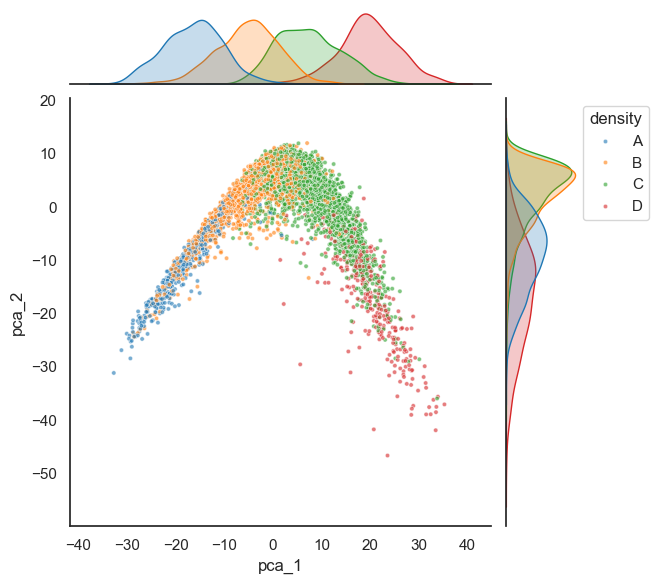

In [31]:
plot_joint(df, 'density', x, y, color_palette)

### Interactive visualisation

With the code below you can interactively explore the latent space to better understand how samples are distributed. You can modify the code to overlay different types of meta information.

In [32]:
df["image_path"] = [
    os.path.join("images", str(df.study_id.values[idx]), str(df.image_id.values[idx]) + ".png")
    for idx in range(len(df))
]

df['color_label'] = 0
df.loc[df['density'] == 'A', 'color_label'] = 0
df.loc[df['density'] == 'B', 'color_label'] = 1
df.loc[df['density'] == 'C', 'color_label'] = 2
df.loc[df['density'] == 'D', 'color_label'] = 3

In [33]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

color = cm.tab10(np.linspace(0, 1, 10))
colorlist = [(np.array(mpl.colors.to_rgb(c))*255).astype(int).tolist() for c in color]*10

colors = [rgb_to_hex(colorlist[c]) for c in df.color_label.values]

In [34]:
def preprocess(image):
    # breast mask
    image_norm = image - np.min(image)
    image_norm = image_norm / np.max(image_norm)
    thresh = cv2.threshold(img_as_ubyte(image_norm), 5, 255, cv2.THRESH_BINARY)[1]

    # Connected components with stats.
    nb_components, output, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=4)

    # Find the largest non background component.
    # Note: range() starts from 1 since 0 is the background label.
    max_label, _ = max(
        [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)],
        key=lambda x: x[1],
    )
    mask = output == max_label
    image_masked = image.copy()
    image_masked[mask == 0] = 0

    return image_masked

In [37]:
out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    sample = df.iloc[points.point_inds[0]]
    img_orig = imread(os.path.join(DATA_DIR, sample.image_path))
    img_proc = preprocess(img_orig)

    s = [6] * len(df)
    for i in points.point_inds:
        s[i] = 12
    with fig.batch_update():
        scatter.marker.size = s

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.imshow(img_orig, cmap='gray')
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(img_proc, cmap='gray')
    ax2.set_title('processed')
    ax2.axis('off')
    plt.show(f)

fig = go.FigureWidget(px.scatter(df, x=x, y=y, template='simple_white', hover_data={'density': True, x:False, y:False}))
fig.update_layout(width=600, height=600)
scatter = fig.data[0]
scatter.on_click(handle_click)
scatter.marker.size = [6] * len(df)
scatter.marker.color = colors

HBox([fig, out])

    'data': [{'customdata': array([['B'],
                                   ['B…